In [3]:
from jax import jit
from main import *
from functools import partial
import time as tm
# Bi modules
bi = bi(platform='cpu')
print(bi.dist.normal(0,1, sample = True, shape=(1,), seed = 1))
bi.net.mat_to_edgl(jnp.array([[1, 2, 3, 4],
                              [5, 6, 7, 8],
                              [9, 10, 11, 12],
                              [13, 14, 15, 16]]))
print(bi.gaussian_process)
print(bi.random_centered)

jax.local_device_count 16
[-1.1842843]
<function Mgaussian.gaussian_process at 0x000002AD64FDB060>
<PjitFunction of <function factors.random_centered at 0x000002AD64FC7CE0>>


In [2]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')

# import data ------------------------------------------------
m.data('resources/data/Howell1.csv', sep=';') 
m.df = m.df[m.df.age > 18]
m.scale(['weight'])
df = m.df
def model(height, weight):    
    a = dist.normal( 178, 20, name = 'a',shape= [1])
    b = dist.lognormal(  0, 1, name = 'b',shape= [1])   
    s = dist.uniform( 0, 50, name = 's',shape = [1])
    lk("y", Normal(a + b * weight , s), obs=height)
m.run(model, num_samples=500) 
m.summary()

g:\OneDrive\Travail\Max Planck\Projects\BI\bi\main.py:153: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  result[arg] = jnp.array(self.df[arg], dtype = self.pandas_to_jax_dtype_map.get(varType))


jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:02<00:00, 405.37it/s, 3 steps of size 7.30e-01. acc. prob=0.92]


,mean,sd,hdi_5.5%,hdi_94.5%
a[0],154.66,0.28,154.25,155.09
b[0],5.81,0.27,5.35,6.22
s[0],5.15,0.19,4.81,5.42


In [ ]:
def mapJax(varType):
    pandas_to_jax_dtype_map = {
                'int64': jnp.int64,
                'int32': jnp.int32,
                'int16': jnp.int32,
                'float64': jnp.float64,
                'float32': jnp.float32,
                'float16': jnp.float16,
            }
        
    return pandas_to_jax_dtype_map.get(varType)


def pd_to_jax(model, df, bit = '32'):
    params = inspect.signature(model).parameters
    args_without_defaults = []
    args_with_defaults = {}
    for param_name, param in params.items():
        if param.default == inspect.Parameter.empty:
            args_without_defaults.append(param_name)
        else:
            args_with_defaults[param_name] = (param.default, type(param.default).__name__)

    test = all(elem in df.columns for elem in args_without_defaults)
    result = dict()
    if test:
        for arg in args_without_defaults:
            varType = str(df[arg].dtype)
            result[arg] = jnp.array(df[arg], dtype = mapJax(varType))
    else:
        return "Error, no"

    for k in args_with_defaults.keys():
        print(args_with_defaults[k][1])
        result[k] = jnp.array(args_with_defaults[k][0], dtype = mapJax(str(args_with_defaults[k][1]) + bit))

    return result     

jax_dict = pd_to_jax(model, df)
mapJax('int32')

Function to visualize distributions

In [210]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_bi_data(m):
    data_dict = m.sampler.get_samples()
    # Initialize an empty DataFrame to collect parameters
    all_params = []

    # Loop through each array in the dictionary
    for key, array in data_dict.items():
        # Check the shape of the array
        if array.ndim > 1 and array.ndim < 3:
            # Create a DataFrame from the array and add a column for each parameter
            param_df = pd.DataFrame(array)
            # Rename columns to include the parameter name
            param_df.columns = [f"{key}_{j+1}" for j in range(array.shape[1])]
            all_params.append(param_df)
    
        elif array.ndim >= 3:# we have a matrix
            array_shape = array.shape
            row = array_shape[1]
            col = array_shape[2]
            for a in range(col):
                for b in range(row):
                    all_params.append(pd.DataFrame({key + '_' + str(a) +  '_' + str(b): array[:,a,b]}))
        else:
            # If it's a 1D array, create a single column DataFrame
            all_params.append(pd.DataFrame({key: array}))

    # Concatenate all parameter DataFrames along the rows
    df_bi = pd.concat(all_params, axis=1)
    return df_bi

def prepare_stan_data(df):
    columns_to_remove = ['lp__',	'accept_stat__',	'stepsize__',	'treedepth__',	'n_leapfrog__',	'divergent__',	'energy__']
    d = df.drop(columns=columns_to_remove)
    return d

def combine_data(df_bi, d):
    #df_bi = pd.DataFrame(samples)
    params = df_bi.columns.values
    d.columns = df_bi.columns

    df_bi['method'] = 'BI'
    d['method'] = 'STAN'
    d_comb = pd.concat([d, df_bi], ignore_index=True)
    return d_comb

def plot_comparaison(m, df):

    d = prepare_stan_data(df)
    df_bi = prepare_bi_data(m)
    d_comb = combine_data(df_bi, d)

    # Calculate the number of rows needed
    params = df_bi.columns.values[:-1]
    num_params = len(params)
    num_cols = 3
    num_rows = (num_params + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5), sharey=True)
    if num_rows * num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    a = 0

    for i in d_comb.columns:
        if i in params:
            if a == 0:
                axes[a].set_ylabel('Density')
                sns.kdeplot(data=d_comb, x=i, hue='method', ax=axes[a], fill=True, color='blue', alpha=0.5, legend=True)
                axes[a].spines['right'].set_visible(False)
                a += 1
            elif a == num_params:
                print('found')
                sns.kdeplot(data=d_comb, x=i, hue='method', ax=axes[a], fill=True, color='blue', alpha=0.5, legend=True)
                a += 1
            elif a < num_params:
                sns.kdeplot(data=d_comb, x=i, hue='method', ax=axes[a], fill=True, color='blue', alpha=0.5, legend=False)
                a += 1


    plt.subplots_adjust(wspace=0.0, left=0.1, right=0.9)
    axes[1].set_yticks([])

    # Remove extra subplots if there are any
    for a in range(len(params), len(axes)):
        fig.delaxes(axes[a])

    plt.subplots_adjust(wspace=0.0, left=0.1, right=0.9)
    axes[1].set_yticks([])
    plt.show()
    return plt


# Rethinking

## 1. Continuous variable: Model (model 4.3)

### 1.1. BI

In [2]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')

# import data ------------------------------------------------
m.data('resources/data/Howell1.csv', sep=';') 
m.df = m.df[m.df.age > 18]
m.scale(['weight'])
# TODO: use jax arrays with hugging face package
m.data_to_model(['weight', 'height'])
#m.list = dict(height =  jnp.array(m.df.height), weight =  jnp.array(m.df.weight))
 # define model ------------------------------------------------
def model(height, weight):    
    a = dist.normal( 178, 20, name = 'a',shape= [1])
    b = dist.lognormal(  0, 1, name = 'b',shape= [1])   
    s = dist.uniform( 0, 50, name = 's',shape = [1])
    lk("y", Normal(a + b * weight , s), obs=height)

# Run sampler ------------------------------------------------
m.run(model, num_samples=500) 
m.summary()

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1179.82it/s, 3 steps of size 7.30e-01. acc. prob=0.92]


,mean,sd,hdi_5.5%,hdi_94.5%
a[0],154.66,0.28,154.25,155.09
b[0],5.81,0.27,5.35,6.22
s[0],5.15,0.19,4.81,5.42


In [95]:
#Example 
def sim(a, b, s, N):
    weight = dist.normal( 80, 50, name = 's',sample = True, shape = (N,))
    return weight, dist.normal( a + b * weight , s, name = 'lk',sample = True)



### 1.2. STAN

In [96]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
nest_asyncio.apply()
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass
stan_code = """
data{
  vector[346] height;
  vector[346] weight;
}
parameters{
  real a;
  real<lower=0> b;
  real<lower=0,upper=50> s;
}
model{
  vector[346] mu;
  s ~ uniform( 0 , 50 );
  b ~ lognormal( 0 , 1 );
  a ~ normal( 178 , 20 );
  for ( i in 1:346 ) {
    mu[i] = a + b* weight[i] ;
  }
  height ~ normal( mu , s );  
  
}
"""
data = {
  'height': m.df.height.values,
  'weight': m.df.weight.values,
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...


Building: 11.8s, done.Messages from stanc:
Warning in '/tmp/httpstan_7k871kz6/model_wn6vk5ei.stan', line 15, column 20: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_7k871kz6/model_wn6vk5ei.stan', line 15, column 14: Argument
    178 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_7k871kz6/model_wn6vk5ei.stan', line 13, column 19: Argument
    50 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
   

Pystan took: 11.9879 seconds


### 1.3. Output comparison 

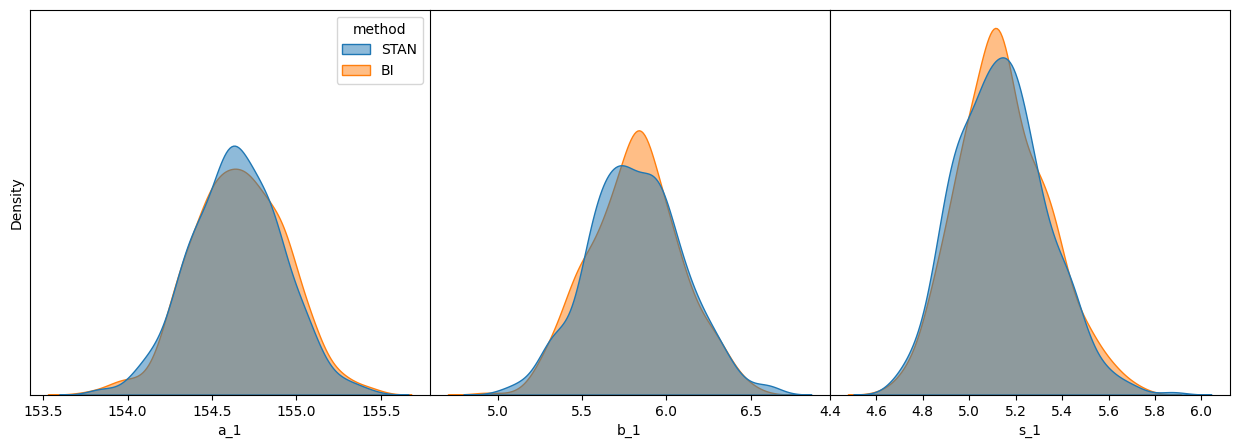

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [97]:
plot_comparaison(m, df)

## 2. Categorical variable: Model (model 5.9)

### 2.1. BI

In [98]:
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
# import data ------------------------------------------------
m.data('resources/data/milk.csv', sep=';') 
m.index(["clade"])
m.scale(['kcal_per_g'])

def model(kcal_per_g, index_clade):
    s = bi.dist.exponential( 1, shape = (1,), name = 's')
    a = bi.dist.normal(0, 0.5, shape=(4,), name = 'a')
    m = a[index_clade]
    lk("y", Normal(m, s), obs=kcal_per_g)


m.data_to_model(['kcal_per_g', "index_clade"])
m.run(model) 
m.sampler.print_summary(0.89)


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1290.74it/s, 3 steps of size 7.20e-01. acc. prob=0.89]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.45      0.21     -0.45     -0.77     -0.11    463.20      1.00
      a[1]      0.35      0.24      0.36      0.02      0.77    687.67      1.00
      a[2]      0.62      0.29      0.63      0.21      1.07    415.39      1.00
      a[3]     -0.54      0.29     -0.55     -1.03     -0.11    475.89      1.00
      s[0]      0.79      0.13      0.78      0.61      0.98    468.86      1.00

Number of divergences: 0


### 2.2. STAN

In [99]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()
stan_code = """
data{
    vector[29] K;
    array[29] int clade_id;
}
parameters{
    vector[4] a;
    real<lower=0> s;
}
model{
    vector[29] mu;
    s ~ exponential( 1 );
    a ~ normal( 0 , 0.5 );
    for ( i in 1:29 ) {
        mu[i] = a[clade_id[i]];
    }
    K ~ normal( mu , s );
    
}
"""
data = {
  'clade_id': m.df.index_clade.values+1,
  'K': m.df.kcal_per_g.values,
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 12.0s, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!


Pystan took: 12.1310 seconds


### 2.3. Output comparaison

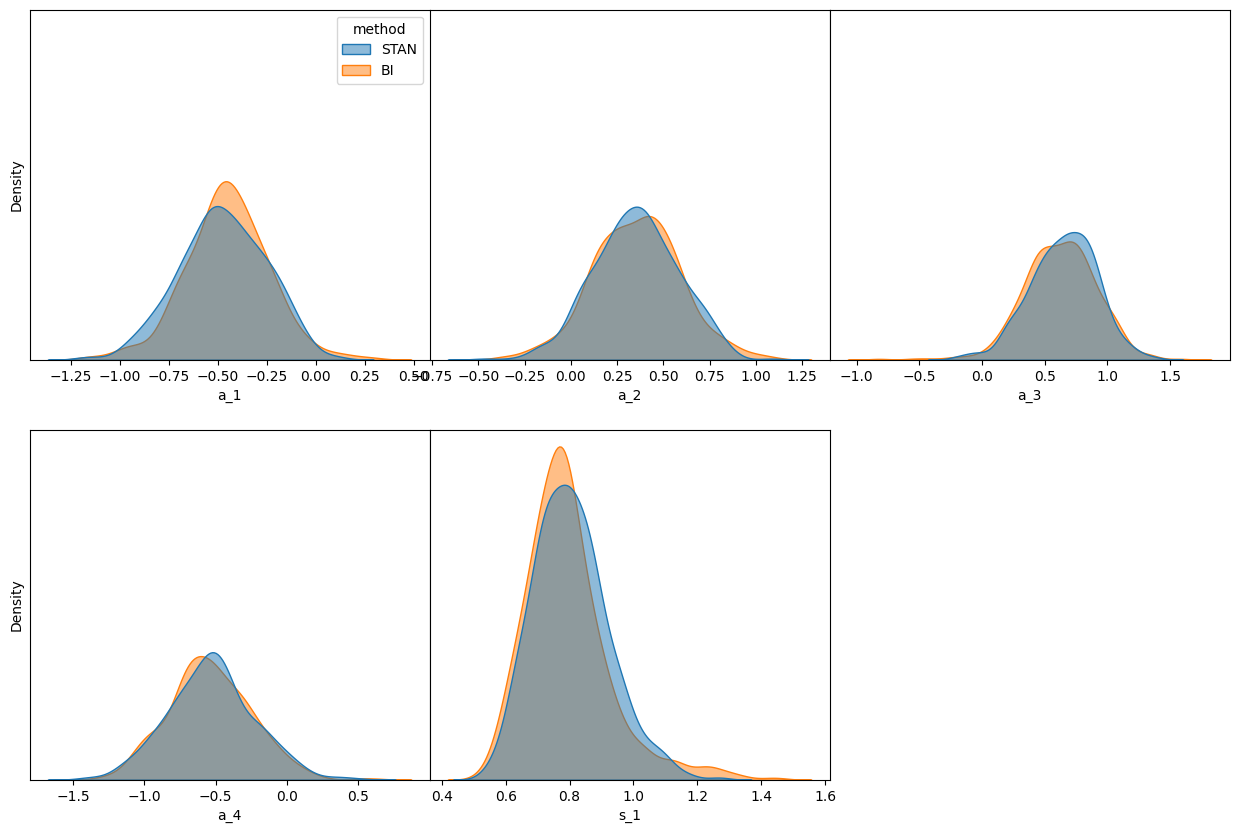

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [100]:
plot_comparaison(m, df)

## 3. Continuous interactions terms (model 8.3)

### 3.1 BI

In [101]:
 # setup platform------------------------------------------------
m = bi(platform='cpu')
# import data ------------------------------------------------
m.data('resources/data/tulips.csv', sep=';') 
m.scale(['blooms', 'water', 'shade'])
m.data_to_model(['blooms', 'water', 'shade'])

 # define model ------------------------------------------------
def model(blooms,shade, water):
    sigma = dist.exponential(1, name = 'sigma')
    bws = dist.normal(0, 0.25, name = 'bws')
    bs = dist.normal(0, 0.25, name = 'bs')
    bw = dist.normal(0, 0.25, name = 'bw')
    a = dist.normal(0.5, 0.25, name = 'a')
    mu = a + bw*water + bs*shade + bws*water*shade
    lk("y", Normal(mu, sigma), obs=blooms)

# Run sampler ------------------------------------------------ 
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1081.93it/s, 7 steps of size 6.46e-01. acc. prob=0.91]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.08      0.10      0.08     -0.08      0.25    606.27      1.00
        bs     -0.31      0.10     -0.32     -0.46     -0.14    666.61      1.00
        bw      0.56      0.11      0.57      0.39      0.74    752.26      1.00
       bws     -0.33      0.10     -0.33     -0.49     -0.16    589.39      1.00
     sigma      0.57      0.10      0.55      0.41      0.72    477.09      1.00

Number of divergences: 0


### 3.2. STAN

In [102]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code = """
data{
    vector[27] blooms_std;
    array[27] int shade_cent;
    array[27] int water_cent;
}
parameters{
    real a;
    real bs;
    real bw;    
    real bws;
    real<lower=0> sigma;
}
model{
    vector[27] mu;
    sigma ~ exponential( 1 );
    bws ~ normal( 0 , 0.25 );
    bs ~ normal( 0 , 0.25 );
    bw ~ normal( 0 , 0.25 );
    a ~ normal( 0.5 , 0.25 );
    for ( i in 1:27 ) {
        mu[i] = a + bw * water_cent[i] + bs * shade_cent[i] + bws * water_cent[i] * shade_cent[i];
    }

    
    blooms_std ~ normal( mu , sigma );
}
"""

data = {
    'blooms_std' : m.df["blooms"].values,
    "water_cent": m.df["water"].values.astype(int),
    "shade_cent": m.df["shade"].values.astype(int),
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 12.3s, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_e8csemox/model_nwjaezfb.stan', line 26, column 4 to column 38)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Pystan took: 12.4235 seconds


### 3.3. Output comparison

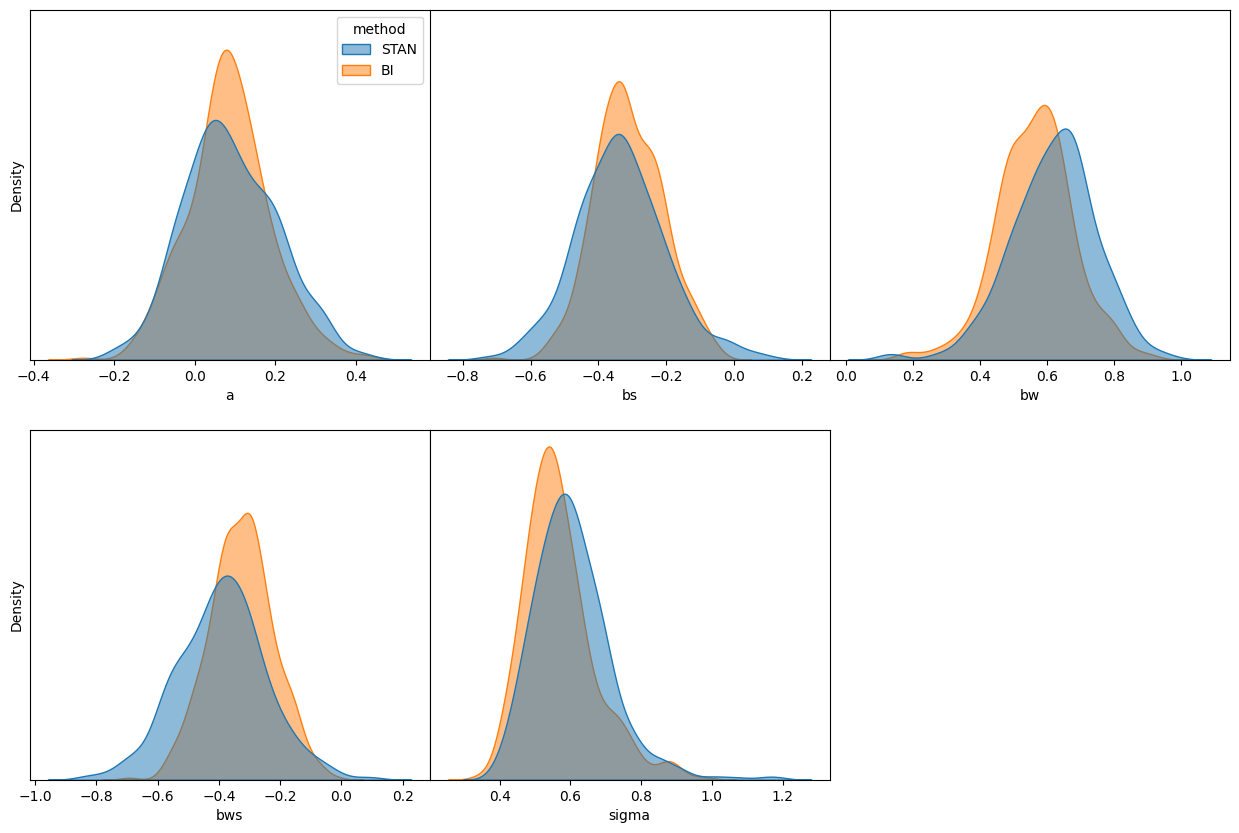

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [103]:
plot_comparaison(m, df)


## 4. Binomial (model 11.1)

### 4.1. BI

In [104]:
import pandas as pd
d = pd.read_csv('resources/data/chimpanzees.csv', sep = ';')
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1

In [105]:
 # setup platform------------------------------------------------
m = bi(platform='cpu')
# import data ------------------------------------------------
m.data('resources/data/chimpanzees.csv', sep=';') 
#m.df['treatment'] =  1 + m.df.prosoc_left + 2 * m.df.condition
#m.df["side"] = m.df.prosoc_left  # right 0, left 1
#m.df["cond"] = m.df.condition  # no partner 0, partner 1
m.data_to_model(['pulled_left', ])

def model(pulled_left):
    a = dist.normal( 0, 10)
    lk("y", Binomial(logits=a), obs=pulled_left)

# Run sampler ------------------------------------------------
m.run(model, init_strategy = numpyro.infer.initialization.init_to_mean()) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1389.20it/s, 1 steps of size 9.55e-01. acc. prob=0.93]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         x      0.33      0.08      0.33      0.19      0.47    206.41      1.00

Number of divergences: 0


### 4.2. STAN

In [106]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code = """
data{
    array[504] int pulled_left;
}
parameters{
    real a;
}
model{
    real p;
    a ~ normal( 0 , 10 );
    p = a;
    p = inv_logit(p);
    pulled_left ~ binomial( 1 , p );    
}
"""

data = {
    'pulled_left' : m.df["pulled_left"].values.astype(int)
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 10.5s, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!


Pystan took: 10.5954 seconds


### 4.3. Output comparison 

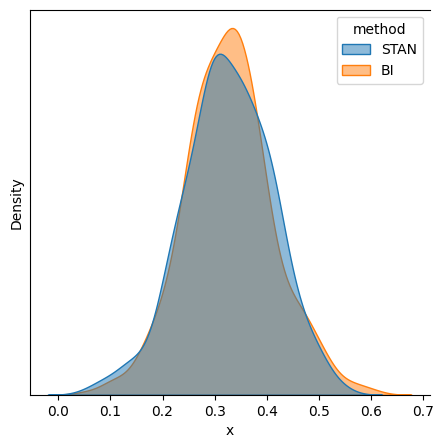

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [107]:
plot_comparaison(m, df)

##  5. Binomial with indices (model 11.4)

### 5.1. BI

In [108]:
m.data('resources/data/chimpanzees.csv', sep=';') 
m.df['treatment'] =  1 + m.df.prosoc_left + 2 * m.df.condition
m.df['actor'] = m.df['actor'] - 1

m.data_to_model(['actor', 'treatment', 'pulled_left'])
m.data_on_model['n_actor'] = len(jnp.unique(jnp.array(m.df["actor"]))) # adding additional information on the dictionary
m.data_on_model['n_treatment'] = len(jnp.unique(jnp.array(m.df["treatment"])))
def model(n_actor, n_treatment, actor, treatment, pulled_left):
    a = dist.normal(0, 1.5, shape = [n_actor], name='a')
    b = dist.normal(0, 0.5, shape = [n_treatment], name='b')
    p = a[actor] + b[treatment]
    lk("y", Binomial(1, logits=p), obs=pulled_left)

# Run sampler ------------------------------------------------
m.run(model) 
# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

sample: 100%|██████████| 1000/1000 [00:03<00:00, 283.97it/s, 1023 steps of size 8.11e-04. acc. prob=0.82]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.19      0.26     -0.20     -0.67      0.20     11.14      1.00
      a[1]      4.03      0.47      4.00      3.38      4.87      6.67      1.26
      a[2]     -0.56      0.28     -0.54     -1.07     -0.19     13.91      1.15
      a[3]     -0.45      0.27     -0.45     -0.94     -0.04     22.04      1.09
      a[4]     -0.06      0.18     -0.08     -0.32      0.23      5.50      1.01
      a[5]      0.73      0.21      0.74      0.39      1.07     27.92      1.16
      a[6]      2.19      0.23      2.19      1.81      2.51     19.04      1.03
      b[0]      0.21      0.46      0.26     -0.67      0.74     15.88      1.11
      b[1]     -0.28      0.23     -0.29     -0.66      0.08     13.83      1.10
      b[2]      0.22      0.24      0.19     -0.08      0.68     10.19      1.02
      b[3]     -0.20      0.19     -0.20     -0.47      0.12      7.61      1.03

Number of divergences: 0


### 5.2. STAN

In [115]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code = """
data{
    array[504] int pulled_left;
    array[504] int treatment;
    array[504] int actor;
}
parameters{
    vector[7] a;
    vector[4] b;
}
model{
    vector[504] p;
    b ~ normal( 0 , 0.5 );
    a ~ normal( 0 , 1.5 );
    for ( i in 1:504 ) {
        p[i] = a[actor[i]] + b[treatment[i]];
        p[i] = inv_logit(p[i]);
    }
    pulled_left ~ binomial( 1 , p );
}

"""

data = {
    'pulled_left' : m.df["pulled_left"].values.astype(int),
    'treatment' : m.df["treatment"].values.astype(int),
    'actor' : m.df["actor"].values.astype(int) +1 
}

start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 11.8s, done.Sampling:   0%
Sampling:   0% (1/1000)
Sampling:  30% (300/1000)
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!


Pystan took: 12.1221 seconds


### 5.3. Output comparison

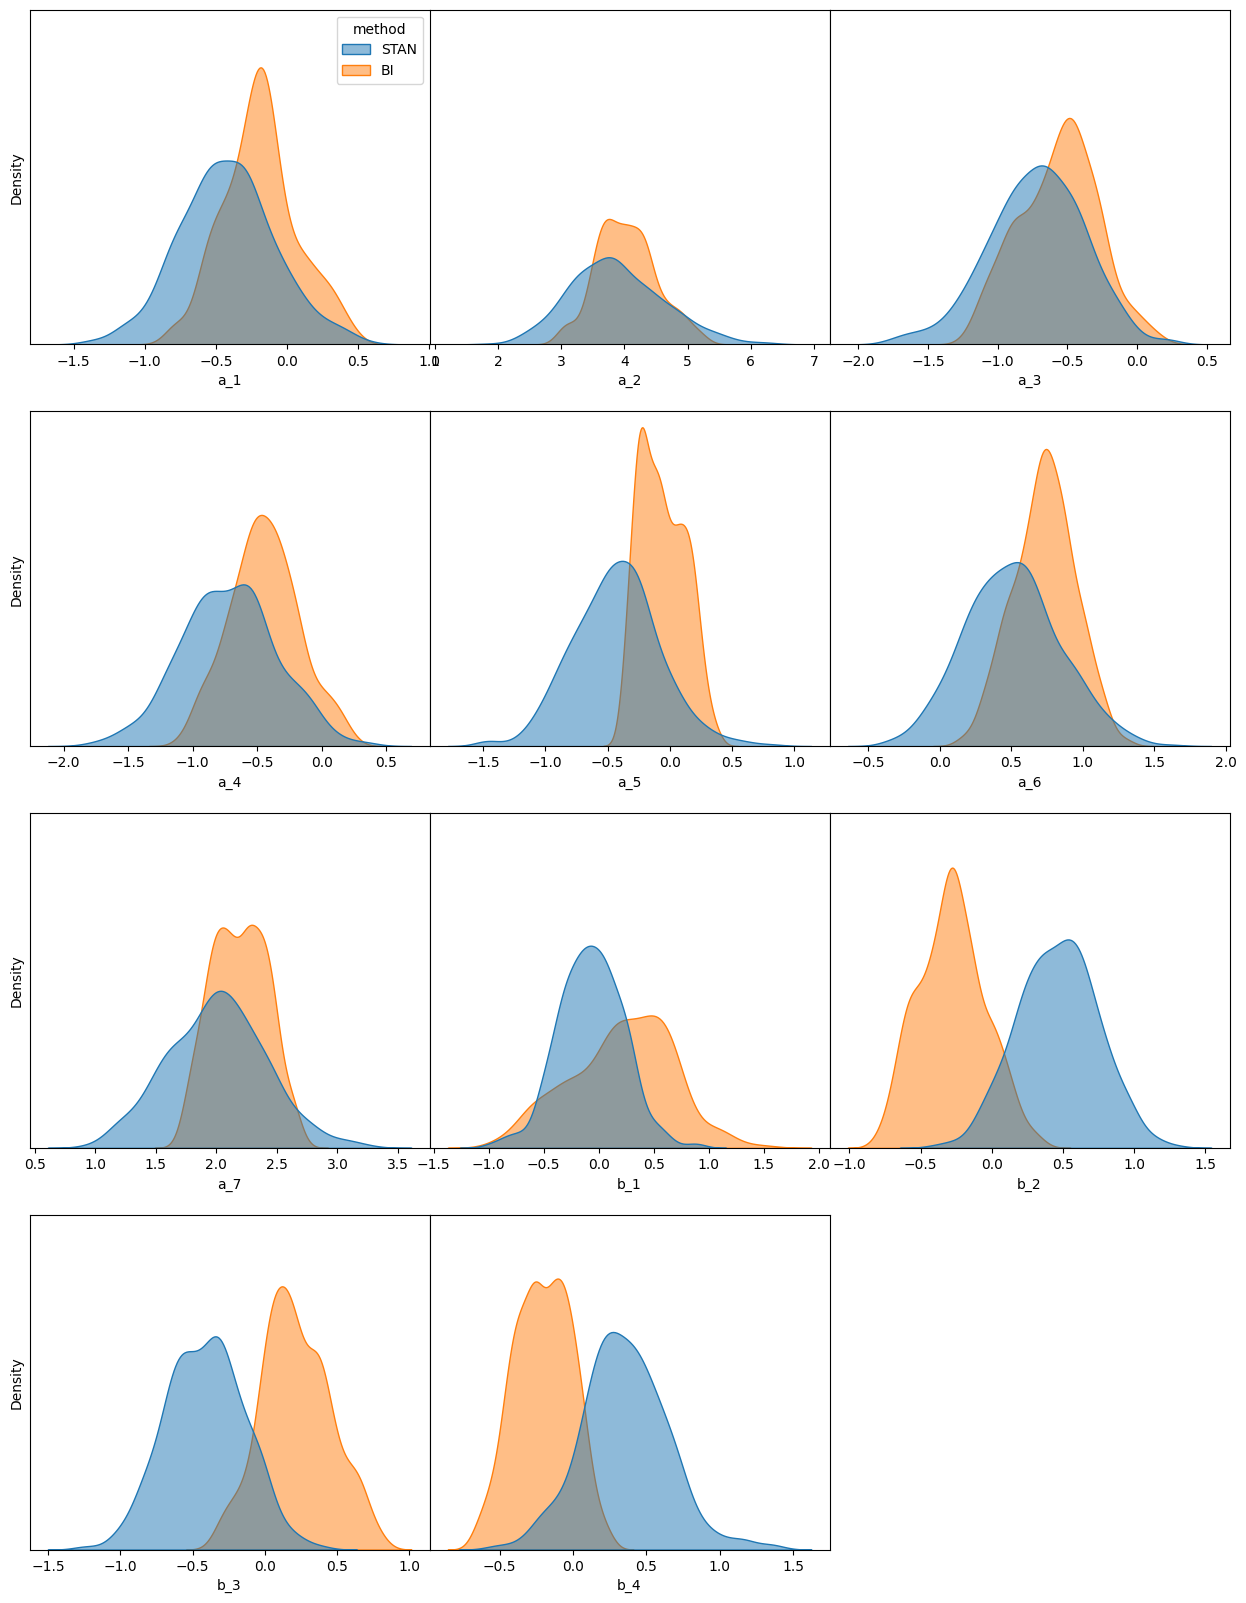

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [116]:
plot_comparaison(m, df)

## 6. Poisson (model 11.10)

### 6.1. BI

In [117]:
import tensorflow as tf
import math
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('resources/data/Kline.csv', sep=';') 
m.scale(['population'])
m.df["cid"] = (m.df.contact == "high").astype(int)
m.data_to_model(['total_tools', 'population', 'cid'])
def model(cid, population, total_tools):
    a = dist.normal(3, 0.5, shape= (2,), name='a')
    b = dist.normal(0, 0.2, shape=(2,), name='b')
    l = jnp.exp(a[cid] + b[cid]*population)
    lk("y", Poisson(l), obs=total_tools)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1185.43it/s, 7 steps of size 5.86e-01. acc. prob=0.92]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      3.21      0.09      3.21      3.06      3.35    413.24      1.01
      a[1]      3.64      0.09      3.64      3.51      3.79    379.41      1.00
      b[0]      0.36      0.05      0.36      0.28      0.45    415.56      1.01
      b[1]      0.05      0.19      0.05     -0.22      0.37    417.77      1.00

Number of divergences: 0


### STAN

In [118]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code = """ 
data{
    array[10] int T;
    vector[10] P;
    array[10] int cid;
}
parameters{
    vector[2] a;
    vector[2] b;
}
model{
    vector[10] lambda;
    b ~ normal( 0 , 0.2 );
    a ~ normal( 3 , 0.5 );
    for ( i in 1:10 ) {
       lambda[i] = a[cid[i]] + b[cid[i]] * P[i];
       lambda[i] = exp(lambda[i]);
    }
    T ~ poisson( lambda );
}

"""

data = {
    'T' : m.df["total_tools"].values.astype(int),
    'P' : m.df["population"].values.astype(float),
    'cid' : m.df["cid"].values.astype(int) +1
}

start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 12.3s, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!


Pystan took: 12.3988 seconds


In [119]:
m.df["cid"]

0    0
1    0
2    0
3    1
4    1
5    1
6    1
7    0
8    1
9    0
Name: cid, dtype: int64

### 5.3. Output comparison

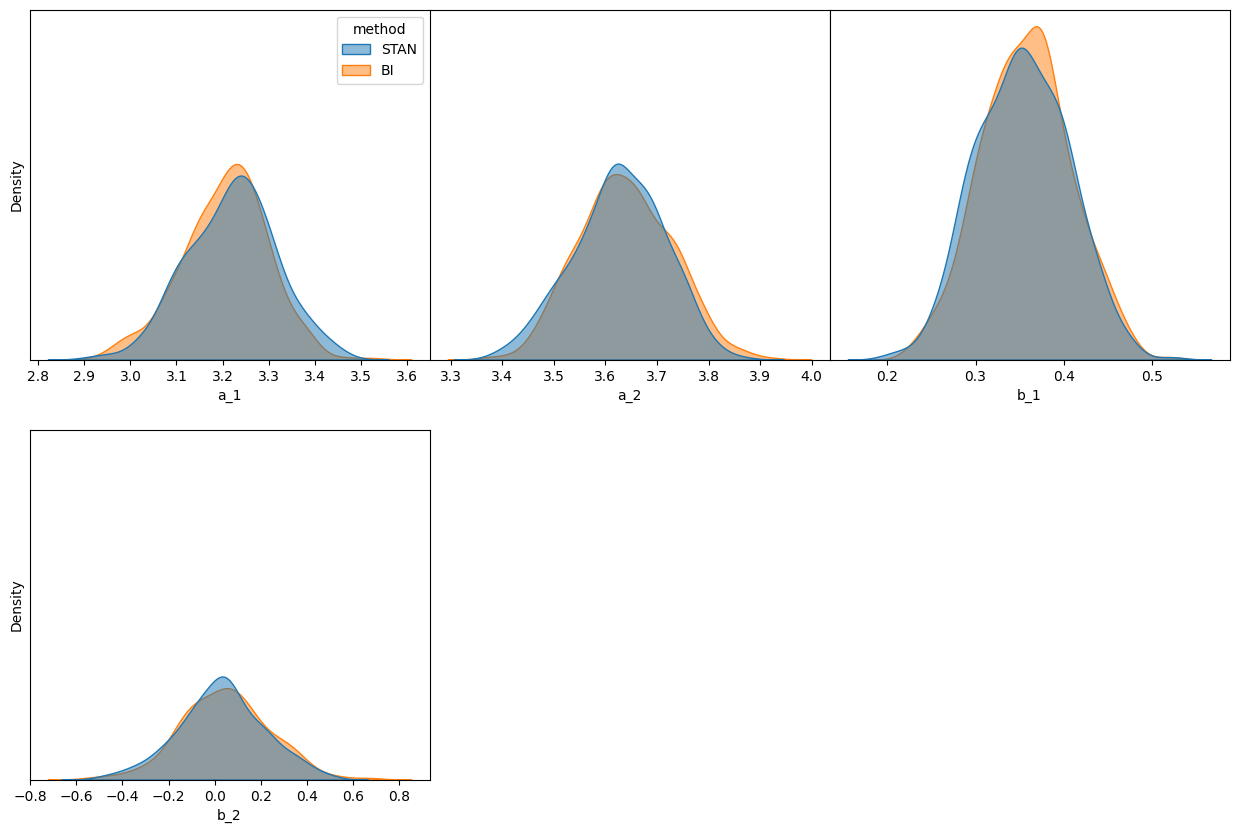

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [120]:
plot_comparaison(m, df)

## 7. Negative binomial (model 11.12) (PB estimation)

### 7.1. Simulated data

In [10]:
import tensorflow_probability.substrates.jax.distributions as tfd
init_key, sample_key = random.split(random.PRNGKey(int(r.randint(0, 10000000))))
init_key = jnp.array(init_key)
num_days = 30
y = tfd.Poisson(rate=1.5).sample(seed = init_key, sample_shape=(num_days,))
num_weeks = 4
y_new = tfd.Poisson(rate=0.5 * 7).sample(seed = init_key, sample_shape=(num_weeks,))
y_all = np.concatenate([y, y_new])
exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])
d = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))
d["log_days"] = d.days.pipe(np.log)
d.to_csv('resources/data/Sim dat Gamma poisson.csv', index=False)

/home/sosa/.local/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:339: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.array(value, dtype=dtype)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_pr

### 7.2. BI

In [122]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data_on_model = dict(
    log_days = jnp.array(d.log_days.values),
    monastery = jnp.array(d.monastery.values),
    output = jnp.array(d.y.values)
)

def model(log_days, monastery, output):
    a = dist.normal(0, 1, shape=[1], name = 'a')
    b = dist.normal(0, 1, shape=[1], name = 'b')
    l = log_days + a +  b * monastery
    lk("y", Poisson(rate = l), obs=output)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1389.90it/s, 7 steps of size 8.49e-01. acc. prob=0.90]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      1.54      0.22      1.53      1.22      1.90    388.66      1.00
      b[0]      0.08      0.67      0.05     -0.81      1.26    392.11      1.00

Number of divergences: 0


### 7.3. STAN

In [123]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code =""" 
data{
    array[34] int y;
    array[34] int monastery;
    vector[34] log_days;
}
parameters{
    real a;
    real b;
}
model{
    vector[34] lambda;
    b ~ normal( 0 , 1 );
    a ~ normal( 0 , 1 );
    for ( i in 1:34 ) {
        lambda[i] = log_days[i] + a + b * monastery[i];
        lambda[i] = exp(lambda[i]);
    }
    
    y ~ poisson( lambda );    
}
"""

data = {
    'y' : np.array(m.data_on_model["output"].astype(int)),
    'monastery' : np.array(m.data_on_model["monastery"].astype(int)) +1,
    'log_days' : np.array(m.data_on_model["log_days"].astype(float)),
}

start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 11.3s, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!


Pystan took: 11.4828 seconds


### 7.4. Output comparison

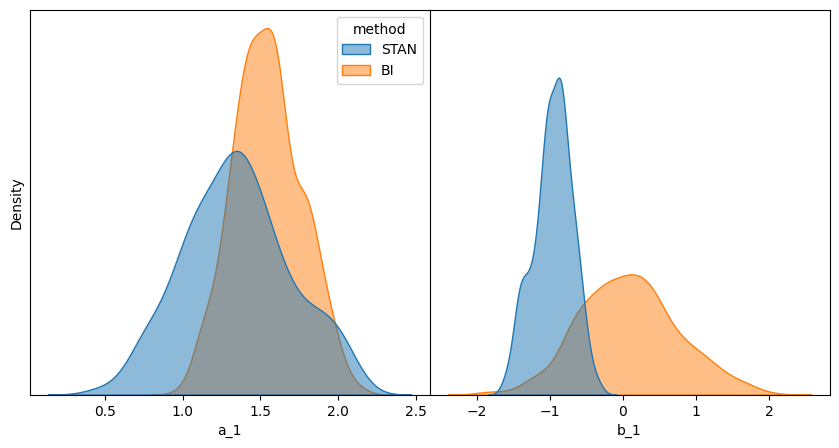

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [124]:
plot_comparaison(m, df)

## 8. Multinomial (model 11.13)

### 8.1. Simulated data

In [ ]:
import tensorflow as tf

# simulate career choices among 500 individuals
N = 500  # number of individuals
income = np.array([1, 2, 5])  # expected income of each career
score = 0.5 * income  # scores for each career, based on income

# next line converts scores to probabilities
p = jnp.array(tf.nn.softmax(score))

# now simulate choice
# outcome career holds event type values, not counts
career = tfd.Categorical(probs=p).sample(seed = init_key, sample_shape = N)
result = [income[index] for index in career]
data = {'career': career, 'income': result}
d = pd.DataFrame(data)
career = jnp.array(d.career.values)
career_income = jnp.array(d.income.values)
income = jnp.array(income)

d.to_csv('resources/data/Sim data multinomial.csv')

### 8.2. BI

In [163]:
m.data_on_model = dict(
    income = income,
    career = career
)

def model(income, career):
    a = dist.normal(0, 1, shape= [2], name = 'a')
    b = bi.dist.normal(0, 0.5, shape=[1], name = 'b')
    s_1 = a[0] + b * income[0]
    s_2 = a[1] + b * income[1]
    s_3 = [0] #pivot
    p = jax.nn.softmax(jnp.stack([s_1[0], s_2[0], s_3[0]]))
    lk("y", Categorical(probs =  p[career]), obs=career)

# Run sampler ------------------------------------------------ 
m.run(model)  

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

sample: 100%|██████████| 1000/1000 [00:01<00:00, 901.41it/s, 7 steps of size 4.16e-01. acc. prob=0.95]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -3.26      0.62     -3.23     -4.21     -2.30    309.71      1.00
      a[1]     -2.03      0.78     -1.99     -3.38     -0.90    196.33      1.00
      b[0]     -1.85      0.39     -1.83     -2.40     -1.18    255.08      1.00

Number of divergences: 0


### 8.3. STAN

In [158]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code =""" 
data{
    int N; // number of individuals
    int K; // number of possible careers
    array[N] int career; // outcome
    vector[K] career_income;
}
parameters{
    vector[K-1] a; // intercepts
    real<lower=0> b; // association of income with choice
}
model{
    vector[K] p;
    vector[K] s;
    a ~ normal( 0 , 1 );
    b ~ normal( 0 , 0.5 );
    s[1] = a[1] + b*career_income[1];
    s[2] = a[2] + b*career_income[2];
    s[3] = 0; // pivot
    p = softmax( s );
    career ~ categorical( p );
}
"""

data = {
    'N' : 500,
    'K' : 3,
    'career' : d["career"].values.astype(int) + 1,
    'career_income' : d["income"].unique().astype(int).tolist(),
}

start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 12.6s, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!


Pystan took: 12.7967 seconds


### 8.4. Output comparison

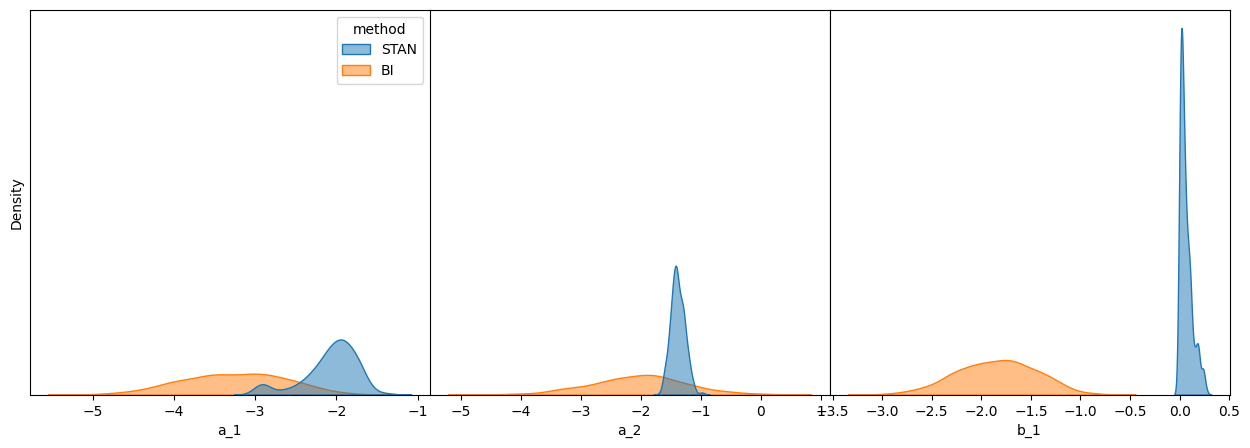

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [164]:
plot_comparaison(m, df)

## 9. Beta binomial (model m12.1)

### 9.1. BI

In [165]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('resources/data/UCBadmit.csv', sep=';') 
m.df["gid"] = (m.df["applicant.gender"] != "male").astype(int)
gid = jnp.array(m.df["gid"].astype('int32').values)
applications = jnp.array(m.df["applications"].astype('float32').values)
admit = jnp.array(m.df["admit"].astype('float32').values)

m.data_on_model = dict(
    gid = gid,
    applications = applications,
    admit =  admit
)

def model(gid, applications, admit):
    phi = dist.exponential(1, shape=[1], name = 'phi')
    alpha = dist.normal( 0., 1.5, shape=[2], name = 'alpha')
    theta = numpyro.deterministic('theta', phi + 2)
    pbar = jax.nn.sigmoid(alpha[gid])
    concentration1 = pbar*theta
    concentration0 = (1 - pbar) * theta
    lk("y", BetaBinomial(total_count = applications, concentration1 = concentration1, concentration0 = concentration0), obs=admit)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:01<00:00, 816.51it/s, 3 steps of size 6.20e-01. acc. prob=0.86]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
  alpha[0]     -0.40      0.43     -0.38     -1.09      0.30    288.51      1.01
  alpha[1]     -0.34      0.43     -0.35     -0.96      0.37    437.26      1.00
    phi[0]      0.98      0.75      0.83      0.00      1.96    270.05      1.00

Number of divergences: 0


### 9.2. STAN

In [166]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()
stan_code =""" 
data{
    array[12] int N;
    array[12] int A;
    array[12] int gid;
}
parameters{
    vector[2] a;
    real<lower=0> phi;
}
transformed parameters{
    real theta;
    theta = phi + 2;
}
model{
    vector[12] pbar;
    phi ~ exponential( 1 );
    a ~ normal( 0 , 1.5 );
    for ( i in 1:12 ) {
        pbar[i] = a[gid[i]];
        pbar[i] = inv_logit(pbar[i]);
    }
    A ~ beta_binomial( N , pbar*theta , (1-pbar)*theta );    
}
"""

data = {
    'A' : m.df["admit"].values.astype(int),
    'N' : m.df["applications"].values.astype(int),
    'gid' : m.df["gid"].values.astype(int) +1,
}

start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 12.7s, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!


Pystan took: 12.8776 seconds


### 9.3. Output comparison

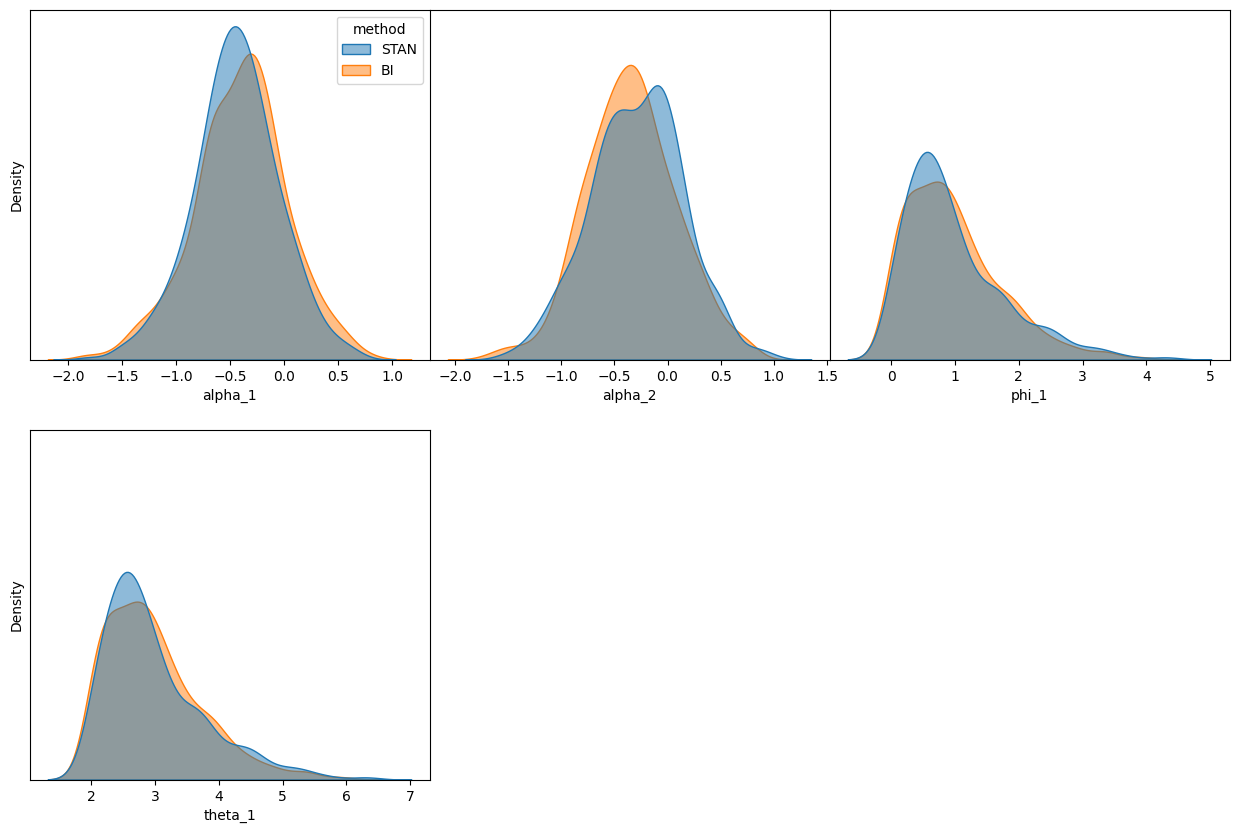

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [167]:
plot_comparaison(m, df)

## 10. Negative-binomial

### 10.1. BI

In [168]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('resources/data/UCBadmit.csv', sep=';') 
m.df["gid"] = (m.df["applicant.gender"] != "male").astype(int)
gid = jnp.array(m.df["gid"].astype('int32').values)
applications = jnp.array(m.df["applications"].astype('float32').values)
admit = jnp.array(m.df["admit"].astype('float32').values)

m.data_on_model = dict(
    gid = gid,
    applications = applications,
    admit =  admit
)

def model(gid, applications, admit):
    phi = dist.exponential(1, shape=[1], name = 'phi')
    alpha = dist.normal(0., 1.5, shape=[2], name = 'alpha')
    theta = phi + 2
    pbar = jax.nn.sigmoid(alpha[gid])
    concentration1 = pbar*theta
    concentration0 = (1 - pbar) * theta
    lk("y", BetaBinomial(total_count = applications, concentration1 = concentration1, concentration0 = concentration0), obs=admit)

# Run sampler ------------------------------------------------
m.run(model) 


# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:01<00:00, 816.81it/s, 3 steps of size 6.20e-01. acc. prob=0.86]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
  alpha[0]     -0.40      0.43     -0.38     -1.09      0.30    288.51      1.01
  alpha[1]     -0.34      0.43     -0.35     -0.96      0.37    437.26      1.00
    phi[0]      0.98      0.75      0.83      0.00      1.96    270.05      1.00

Number of divergences: 0


### 10.2. STAN

## 11. Zero inflated outcomes

### 11.1. BI

In [169]:
from jax.scipy.special import expit
r.seed(42)
# Define parameters
prob_drink = 0.2  # 20% of days
rate_work = 1     # average 1 manuscript per day

# sample one year of production
N = 365

np.random.seed(365)
drink = np.random.binomial(1, prob_drink, N)
y = (1 - drink) * np.random.poisson(rate_work, N)
d = pd.DataFrame(y)
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------

m.data_on_model = dict(
    y = jnp.array(y)
)

def model(y):
    al = dist.normal( 1, 0.5, [1] , name = 'al')
    ap = dist.normal( -1.5, 1, [1], name = 'ap')
    p = expit(ap)
    lambda_ = jnp.exp(al)
    lk("y", ZeroInflatedPoisson(p, lambda_), obs=y)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1132.83it/s, 15 steps of size 5.52e-01. acc. prob=0.94]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        al      0.12      0.08      0.12     -0.02      0.24    196.44      1.00
        ap     -1.35      0.32     -1.33     -1.82     -0.86    266.48      1.00

Number of divergences: 0


### 11.2. STAN

In [170]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()
stan_code = """ 
data{
    array[365] int y;
}
parameters{
    real ap;
    real al;
}
model{
    real p;
    real lambda;
    al ~ normal( 1 , 0.5 );
    ap ~ normal( -1.5 , 1 );
    lambda = al;
    lambda = exp(lambda);
    p = ap;
    p = inv_logit(p);
    for ( i in 1:365 ) {
        if ( y[i]==0 )
            target += log_mix( p , 0 , poisson_lpmf(0|lambda) );
        if ( y[i] > 0 )
            target += log1m( p ) + poisson_lpmf(y[i] | lambda );
    }
}
"""
data = {
    'y' :d.iloc[:,0].values.astype(int)
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 10.6s, done.Sampling:   0%
Sampling:   0% (1/1000)
Sampling:  40% (400/1000)
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 5.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
  Adjust your expectations accordingly!


Pystan took: 10.8475 seconds


### 11.3. Output comparison

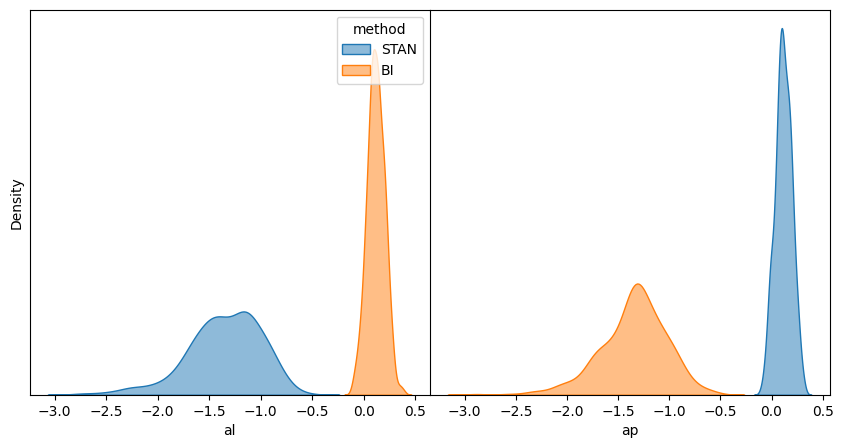

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [171]:
plot_comparaison(m, df)

## 12. OrderedLogistic (Todo: PB)

In [172]:
#import numpyro.distributions as dist
## setup platform------------------------------------------------
#m = bi()
## import data ------------------------------------------------
#m.data('resources/data/Trolley.csv', sep=';') 
#d = m.df
## discrete proportion of each response value
#pr_k = d.response.value_counts().sort_index().values / d.shape[0]
## cumsum converts to cumulative proportions
#cum_pr_k = jnp.cumsum(pr_k, -1)
#logit = lambda x: jnp.log(x / (1 - x))  # convenience function
#lco = logit(cum_pr_k)

In [173]:
#import numpyro.distributions as distnp
#from numpyro.distributions.transforms import OrderedTransform
## setup platform------------------------------------------------
#m = bi()
#m.data_on_model = dict(response = jnp.array(d.response.values - 1))
#def model(response):
#    cutpoints = numpyro.sample(
#        
#        distnp.TransformedDistribution("cutpoints",
#            distnp.Normal(0, 1.5), OrderedTransform()
#        ),
#    )
#    numpyro.sample("R", dist.OrderedLogistic(0, cutpoints), obs=response)
#
## Run sampler ------------------------------------------------
#start = tm.time()    
#m.run(model) 
#end = tm.time()    
#print(f"BI took: {end - start:.4f} seconds")
#
## Diagnostic ------------------------------------------------
#m.sampler.print_summary(0.89)

## 13. Varying interceps

### 13.1. BI

In [174]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('resources/data/reedfrogs.csv', sep=';') 
m.df["tank"] = np.arange(m.df.shape[0])
tank = jnp.array(m.df["tank"].astype('int32').values)
density = jnp.array(m.df["density"].astype('float32').values)
surv = jnp.array(m.df["surv"].astype('int32').values)
m.data_on_model = dict(
    tank = tank,
    surv = surv
)

def model(tank, surv):
    sigma = dist.exponential( 1, shape = [1], name = 'sigma')
    a_bar = dist.normal( 0., 1.5, shape= [1], name = 'a_bar')
    alpha = dist.normal( a_bar, sigma, shape= [48], name = 'alpha')
    p = alpha[tank]
    lk("y", Binomial(total_count = density, logits = p), obs=surv)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1027.43it/s, 23 steps of size 4.29e-01. acc. prob=0.89]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
  a_bar[0]      1.35      0.25      1.33      0.99      1.74    406.47      1.00
  alpha[0]      2.19      0.92      2.08      0.73      3.54    411.79      1.00
  alpha[1]      3.03      1.12      2.97      1.07      4.48    550.43      1.00
  alpha[2]      1.01      0.65      0.98      0.04      2.03    609.51      1.00
  alpha[3]      3.08      1.13      2.92      1.39      4.74    473.28      1.00
  alpha[4]      2.08      0.83      2.03      0.61      3.22    676.53      1.00
  alpha[5]      2.12      0.80      2.09      0.73      3.28    408.50      1.01
  alpha[6]      3.09      1.17      2.95      1.22      4.71    334.58      1.00
  alpha[7]      2.16      0.90      2.10      0.77      3.49    843.15      1.00
  alpha[8]     -0.17      0.58     -0.16     -0.98      0.83    500.83      1.00
  alpha[9]      2.12      0.82      2.04      0.83      3.34    675.58      1.00
 alpha[10]      1.02      0

### 13.2. STAN

In [175]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()
stan_code = """ 
data{
    array[48] int N;
    array[48] int S;
    array[48] int tank;
}
parameters{
    vector[48] a;
    real a_bar;
    real<lower=0> sigma;
}
model{
    vector[48] p;
    sigma ~ exponential( 1 );
    a_bar ~ normal( 0 , 1.5 );
    a ~ normal( a_bar , sigma );
    for ( i in 1:48 ) {
        p[i] = a[tank[i]];
        p[i] = inv_logit(p[i]);
    }
    S ~ binomial( N , p );
}
"""
data = {
    'S' : m.df['surv'].values.astype(int),
    'N' : m.df['density'].values.astype(int),
    'tank' : m.df['tank'].values.astype(int)+1,
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!


Pystan took: 0.1984 seconds


### 13.3. Output comparison

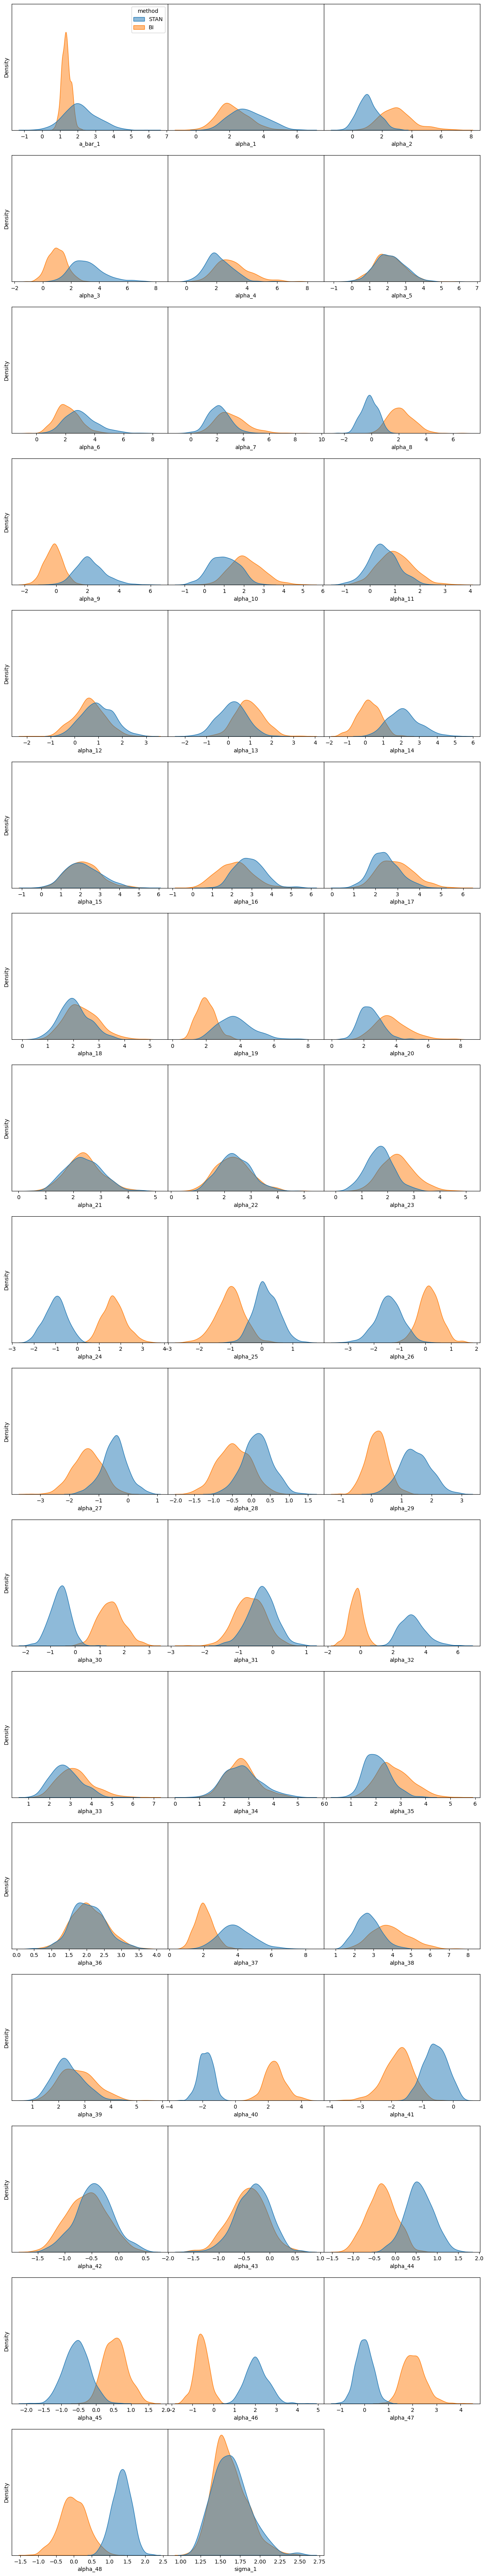

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [176]:
plot_comparaison(m, df)

## 14. Varying effects

### 14.1. Data simulation

In [9]:
import numpyro.distributions as dd
a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes
Mu = jnp.array([a, b])
cov_ab = sigma_a * sigma_b * rho
Sigma = jnp.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
jnp.array([1, 2, 3, 4]).reshape(2, 2).T
sigmas = jnp.array([sigma_a, sigma_b])  # standard deviations
Rho = jnp.array([[1, rho], [rho, 1]])  # correlation matrix

# now matrix multiply to get covariance matrix
Sigma = jnp.diag(sigmas) @ Rho @ jnp.diag(sigmas)

N_cafes = 20
seed = random.PRNGKey(5)  # used to replicate example
vary_effects = bi.dist.multivariatenormal(Mu, Sigma, shape=(N_cafes,), sample = True)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

seed = random.PRNGKey(22)
N_visits = 10
afternoon = jnp.tile(jnp.arange(2), N_visits * N_cafes // 2)
cafe_id = jnp.repeat(jnp.arange(N_cafes), N_visits)
mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes
wait = dist.normal(mu, sigma, sample = True)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
d.to_csv('resources/data/Sim data multivariatenormal.csv', index=False)

### 14.2.BI

In [178]:
# import data ------------------------------------------------
m = bi()
m.data_on_model = dict(
    cafe = cafe_id, 
    wait = wait, 
    N_cafes = N_cafes
)
def model(cafe, wait, N_cafes):
    a = dist.normal(5, 2, name = 'a')
    b = dist.normal(-1, 0.5, name = 'b')
    sigma_cafe = dist.exponential(1, shape=[2], name = 'sigma_cafe')
    sigma = dist.exponential( 1, shape=[1], name = 'sigma')
    Rho = dist.lkj(2, 2, name = 'Rho')
    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
    a_cafe_b_cafe = dist.multivariatenormal(jnp.stack([a, b]), cov, shape = [N_cafes], name = 'a_cafe')    

    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    lk("y", Normal(mu, sigma), obs=wait)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:01<00:00, 518.37it/s, 127 steps of size 3.13e-02. acc. prob=0.99]



                   mean       std    median      5.5%     94.5%     n_eff     r_hat
     Rho[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
     Rho[0,1]     -0.47      0.34     -0.53     -0.98     -0.04    116.23      1.01
     Rho[1,0]     -0.47      0.34     -0.53     -0.98     -0.04    116.23      1.01
     Rho[1,1]      1.00      0.00      1.00      1.00      1.00    363.54      1.00
            a      3.51      0.17      3.52      3.21      3.76    225.61      1.03
  a_cafe[0,0]      3.22      0.18      3.22      2.92      3.47    512.84      1.00
  a_cafe[0,1]     -0.84      0.15     -0.82     -1.07     -0.61    324.48      1.01
  a_cafe[1,0]      4.36      0.19      4.34      4.09      4.70    372.76      1.00
  a_cafe[1,1]     -0.98      0.18     -0.96     -1.27     -0.71    157.51      1.01
  a_cafe[2,0]      3.71      0.19      3.71      3.43      4.01    406.81      1.00
  a_cafe[2,1]     -0.86      0.17     -0.88     -1.14     -0.60    324.84  

### 14.3. STAN

In [179]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
import numpy as np
#try:
#  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
#except:
#  pass

nest_asyncio.apply()
stan_code = """ 
data{
    int len;
    int N_cafes;
    vector[len] wait;
    array[len] int afternoon;
    array[len] int cafe;
}
parameters{
    vector[N_cafes] b_cafe;
    vector[N_cafes] a_cafe;
    real a;
    real b;
    vector<lower=0>[2] sigma_cafe;
    real<lower=0> sigma;
    corr_matrix[2] Rho;
}
model{
    vector[len] mu;
    Rho ~ lkj_corr( 2 );
    sigma ~ exponential( 1 );
    sigma_cafe ~ exponential( 1 );
    b ~ normal( -1 , 0.5 );    
    a ~ normal( 5 , 2 );
    {
        array[N_cafes] vector[2] YY;
        vector[2] MU;
        MU = [ a , b ]';
        for ( j in 1:N_cafes ) YY[j] = [ a_cafe[j] , b_cafe[j] ]';
        YY ~ multi_normal( MU , quad_form_diag(Rho , sigma_cafe) );
    }
    for ( i in 1:len ) {
        mu[i] = a_cafe[cafe[i]] + b_cafe[cafe[i]] * afternoon[i];        
    }
    
    wait ~ normal( mu , sigma );

}
"""
data = {
    'wait' : d['wait'].values.astype(float),
    'afternoon' : d['afternoon'].values.astype(int),
    'cafe' : d['cafe'].values.astype(int)+1,
    'N_cafes' : N_cafes,
    'len' : len(d['wait'].values)
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 25.4s, done.Messages from stanc:
Warning in '/tmp/httpstan_w7qcpffr/model_ls33iryf.stan', line 20, column 4: It
    is suggested to reparameterize your model to replace lkj_corr with
    lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run
    slower, consume more memory, and has higher risk of numerical errors.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1000)
Sampling:  20% (200/1000)
Sampling:  30% (300/1000)
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected becaus

Pystan took: 25.9844 seconds


### 14.4 Output comparison

In [180]:
prepare_stan_data(df).shape

(500, 49)

/tmp/ipykernel_159245/86858333.py:75: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=d_comb, x=i, hue='method', ax=axes[a], fill=True, color='blue', alpha=0.5, legend=True)
/tmp/ipykernel_159245/86858333.py:83: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=d_comb, x=i, hue='method', ax=axes[a], fill=True, color='blue', alpha=0.5, legend=False)


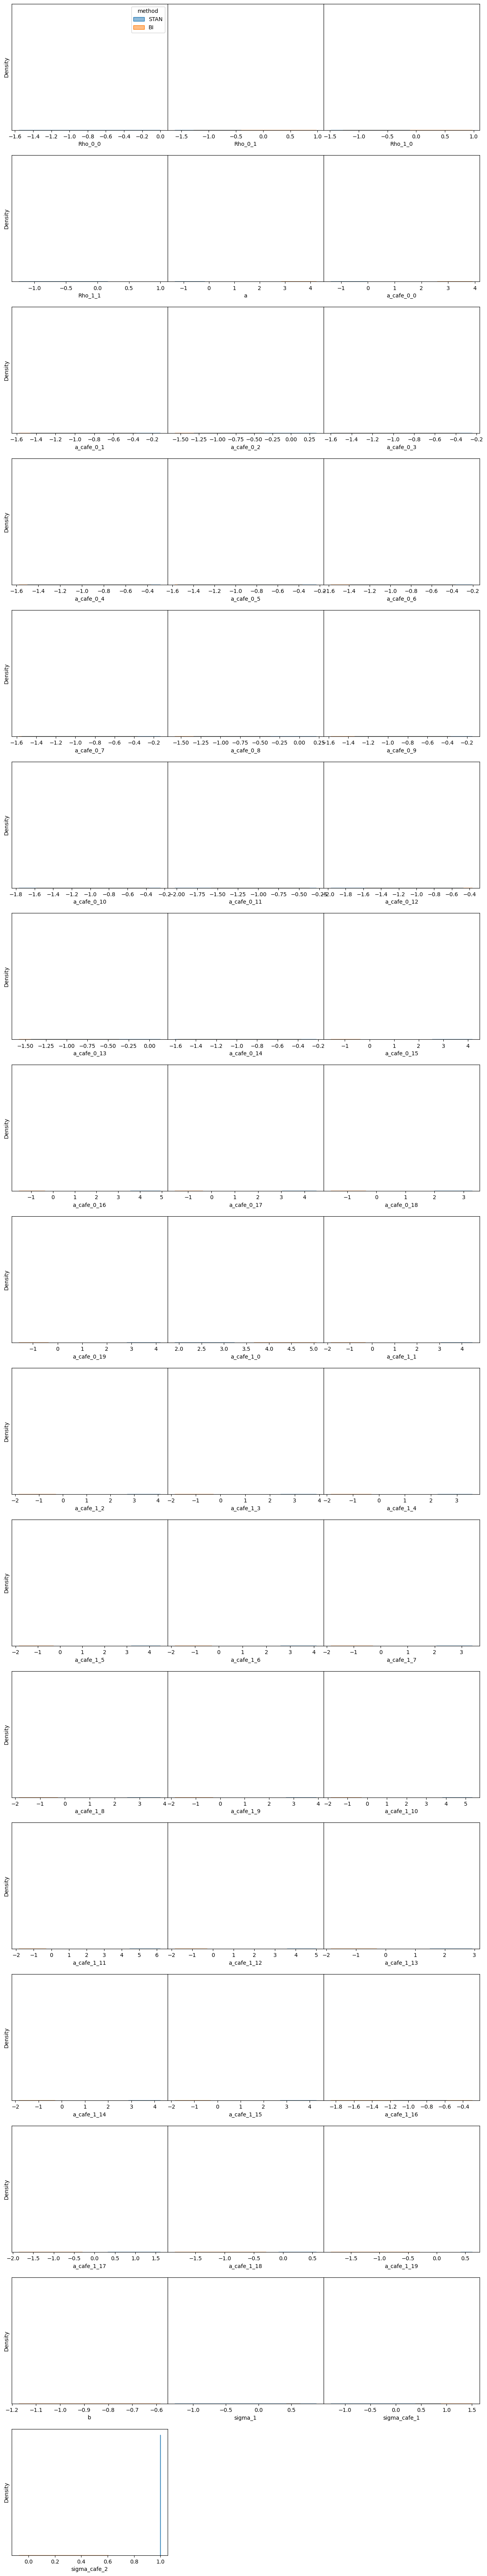

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [211]:
plot_comparaison(m, df)

## 15 Multiple random effects


## 16. Gaussian Processes

In [213]:
import time as tm
from main import*
Kline2 = pd.read_csv('resources/data/Kline2.csv', sep=";")
islandsDistMatrix = pd.read_csv('resources/data/islandsDistMatrix.csv'"", index_col=0)
d = Kline2
d["society"] = range(1, 11)  # index observations

dat_list = dict(
    T=d.total_tools.values,
    P=d.population.values,
    society=d.society.values - 1,
    Dmat=islandsDistMatrix.values,
)

# setup platform------------------------------------------------
m14_8 = bi(platform='cpu')
m14_8.data = dat_list

@jit
def cov_GPL2(x, sq_eta, sq_rho, sq_sigma):
    N = x.shape[0]
    K = sq_eta * jnp.exp(-sq_rho * jnp.square(x))
    K = K.at[jnp.diag_indices(N)].add(sq_sigma)
    return K


def model(Dmat, P, society, T):
    a = exponential('a', [1], 1)
    b = exponential('b',[1],1)
    g = exponential('g',[1],1)
    etasq = exponential('etasq',[1],2)
    rhosq = exponential('rhosq',[1],0.5)

    # non-centered Gaussian Process prior
    SIGMA = cov_GPL2(Dmat, etasq, rhosq, 0.01)
    L_SIGMA = jnp.linalg.cholesky(SIGMA)
    z = normal('z', [10], 0, 1)
    k = (L_SIGMA @ z[..., None])[..., 0]
    lambda_ = a * P**b / g * jnp.exp(k[society])
    sample("T", Poisson(lambda_), obs=T)

# Run sampler ------------------------------------------------
start = tm.time()    
m14_8.run(model) 
end = tm.time()    
print(f"BI took: {end - start:.4f} seconds")
m14_8.sampler.print_summary(0.89)

FileNotFoundError: [Errno 2] No such file or directory: 'resources/data/Kline2.csv'